In [ ]:
# For Fourier embedding
if Fourier_embedding == True:
    sigma = 2
    input_dim = 20
    B = nn.Parameter(sigma*torch.randn(1,int(0.5*input_dim),dtype=torch.float64),requires_grad=False)
    
# Fourier Embedding layer funtion
def Fourier(X):
    X = X@B # 이게 행렬곱이라면? matmul 이나 einsum 같은거겠지. 그럼 b의 쉐입이 어떻게 되는데?
    X = torch.cat((torch.sin(X),torch.cos(X)),-1)
    return X

# Forward pass function 
def forward( x):
    # Normalization for input
    x = (x-X_mean)/X_std

    # If Fourier embedding is used, apply the Fourier embedding layer
    if Fourier_embedding ==True:
        x = Fourier(x)

1st difference
(535, 6, 229)


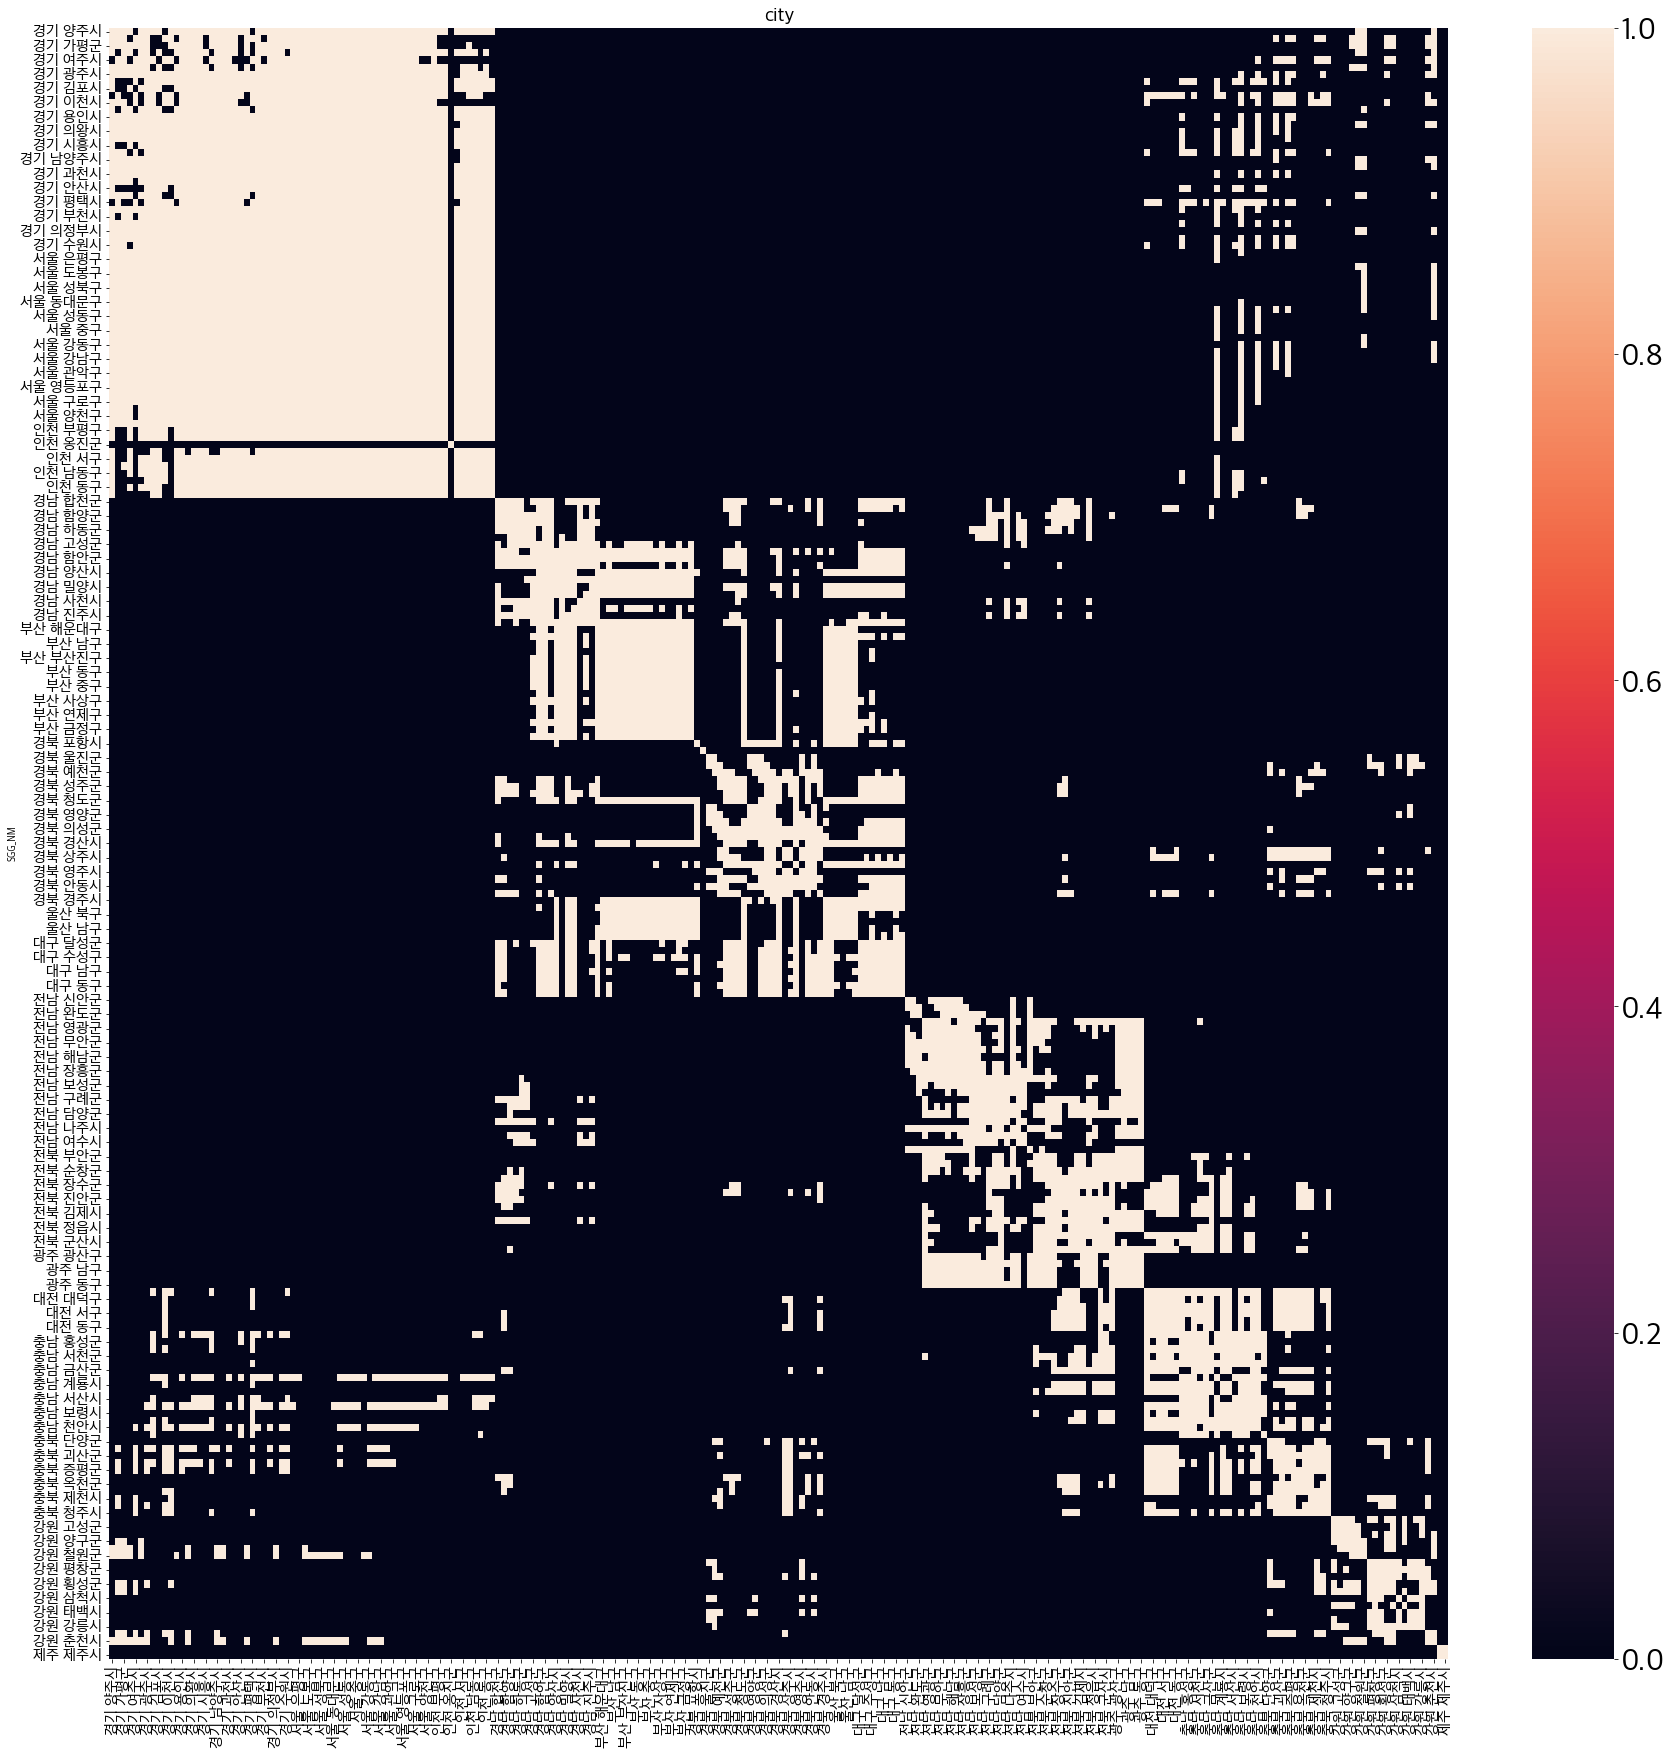

In [155]:
# import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import os
import torch
import shutil

from lib import PairDataset
from lib import Data2Graph
from lib import compute_metrics
from lib import matplotlib_plot_font
from lib import save_figure_predict
from lib import Trainer
from lib import preprocess_data
from model_select import model_selection

matplotlib_plot_font()

MODEL_NAME = "GCN"
diff_ = '1st'
tmp = '_'+diff_ # custom folder name
TIME_STEPS = 5
BATCH_SIZE = 16
EPOCHS = 50
learning_rate = 1e-3
validation_ratio = 0.2
device = torch.device('cuda', 0) if torch.cuda.is_available() else torch.device('cpu')

# Load Data
region_type = 'city'
dataset_name = 'covid_alpha'
dist_mx = pd.read_csv(f'./Data/distances_kr_{region_type}_adj_mx.csv', encoding='cp949', index_col=0)

# data는 1로 고정
df = pd.read_csv(f'Data/KCDC_data/Processing_Results/smoothing_1_{region_type}_mean.csv', index_col=0, encoding='cp949')
df = df.iloc[1:707] # 델타 : 554, 540, 533 오미크론 : 707, 693, 686 / 402 ~ 20210226 백신
# df = df.iloc[:340] # 델타 : 554, 540, 533 오미크론 : 707, 693, 686 / 402 ~ 20210226 백신 ~402
region_dict = {}
for i, region in enumerate(df.columns):
    region_dict[i] = region 

#####################
## TEST START DATE ##
#####################    
split_date = '2021-11-25' #'2021-11-25' #'2021-06-25' 
# split_date = '2020-11-23' # df[:402]


train, val, test, scaler, horizon = preprocess_data(data = df,
                                                    val_ratio=validation_ratio,
                                                    split_date=split_date,
                                                    time_steps=TIME_STEPS,
                                                    diff_=diff_)

train_dl = DataLoader(PairDataset(train[0], train[1]), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(PairDataset(val[0], val[1]), batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(PairDataset(test[0], test[1]), batch_size=1, shuffle=False)
# [Batch, node, time, channel]

MAE_total_list, MAPE_total_list, RMSE_total_list, idx_list = [], [], [], []

network = 'dist_01'
norm = 0.5


result_dir = ('%s_%s_%s'+tmp) % (MODEL_NAME, network, norm)
model_dir = ('%s_%s_%s'+tmp) % (MODEL_NAME, network, norm)
Network_path = os.path.join('Result', dataset_name, 'Network', str(horizon), result_dir)
Figure_path = os.path.join('Result', dataset_name, 'Figure', str(horizon), result_dir)
Diameter_path = os.path.join('Result', dataset_name, 'Diameter', str(horizon), result_dir)
Pred_path = os.path.join('Result', dataset_name, 'Pred', str(horizon), result_dir)
model_path = os.path.join('Save_model', dataset_name, str(horizon), model_dir)

if os.path.exists(Network_path):
    shutil.rmtree(Network_path) # 최종 경로로 해야함
if os.path.exists(Figure_path):
    shutil.rmtree(Figure_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(Diameter_path):
    shutil.rmtree(Diameter_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(Pred_path):
    shutil.rmtree(Pred_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(model_path):
    shutil.rmtree(model_path) # 해당 경로 데이터 모두 삭제
    
os.makedirs(Network_path) # 새로 폴더 생성
os.makedirs(Figure_path) # 새로 폴더 생성
os.makedirs(Diameter_path) # 새로 폴더 생성
os.makedirs(Pred_path) # 새로 폴더 생성
os.makedirs(model_path) # 새로 폴더 생성

data2network = Data2Graph(distance_matrix = dist_mx, temporal_data = df)
G, adj_mx, graph_type = data2network.make_network(network_type=network,
                                                region_type=region_type,
                                                norm=norm,
                                                int_adj=True,
                                                Diameter_path = Diameter_path)
data2network.save_graph_html(enc=region_dict,
                             title=region_type,
                             save_name=f'{graph_type}_{norm}',
                             Network_path = Network_path)

In [156]:
import numpy as np
print('number of edges : ', adj_mx[adj_mx>0].__len__())
print('number of nodes : ', adj_mx.shape[0])
percent = 0
nnz =adj_mx.nonzero() # 연결되어있는 엣지 쌍을 반환
perm = np.random.permutation(nnz) # 엣지 쌍의 순서를 섞어줌
drop_nnz = int(len(nnz)*percent) # 엣지 쌍의 길이에 드롭 할 퍼센트를 곱해줌
print(len(nnz), drop_nnz)
perm = perm[:drop_nnz] # 드롭할 만큼의 엣지 쌍을 반환

row = perm.transpose(1,0)[0] # 전치 후 첫번째 열은 source node
col = perm.transpose(1,0)[1] # 전치 후 두번째 열은 target node 
adj_mx[row, col] = 0 # 이 부분을 0으로 drop 해줌

print('number of edges after drop : ', adj_mx[adj_mx>0].__len__())

number of edges :  9189
number of nodes :  229
9189 0
number of edges after drop :  9189


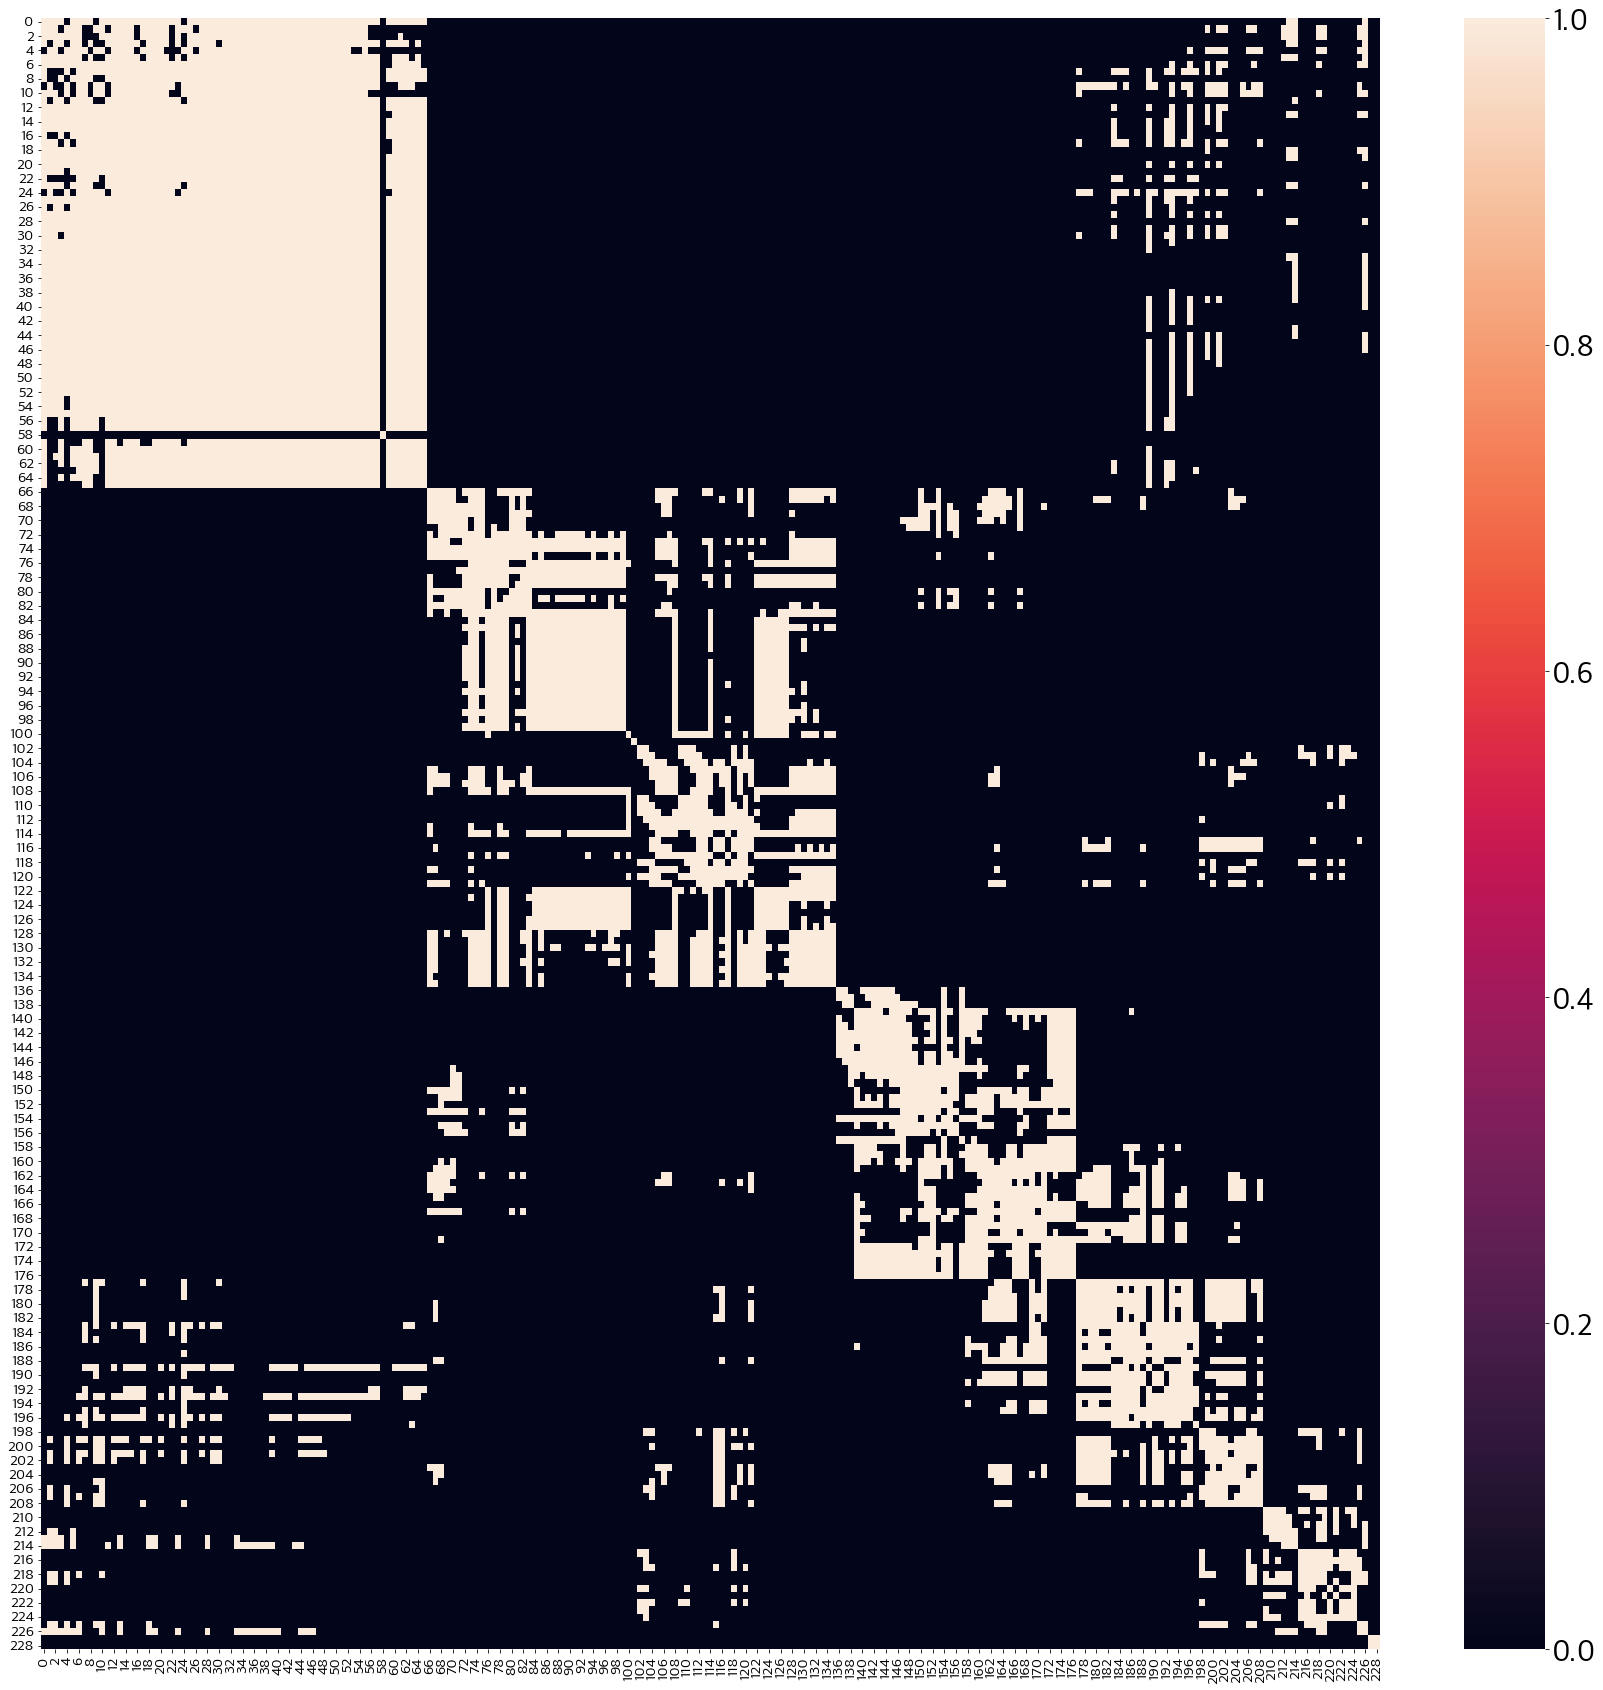

In [158]:

import seaborn as sns
import matplotlib.pyplot as plt
tmp = pd.DataFrame(adj_mx.numpy())#, columns = dist_mx.columns, index = dist_mx.index)
plt.figure(figsize=(30,30))
g=sns.heatmap(tmp) #annot=True,

cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.yticks(fontsize=15, rotation=0)
plt.xticks(fontsize=15, rotation=90)
plt.show()

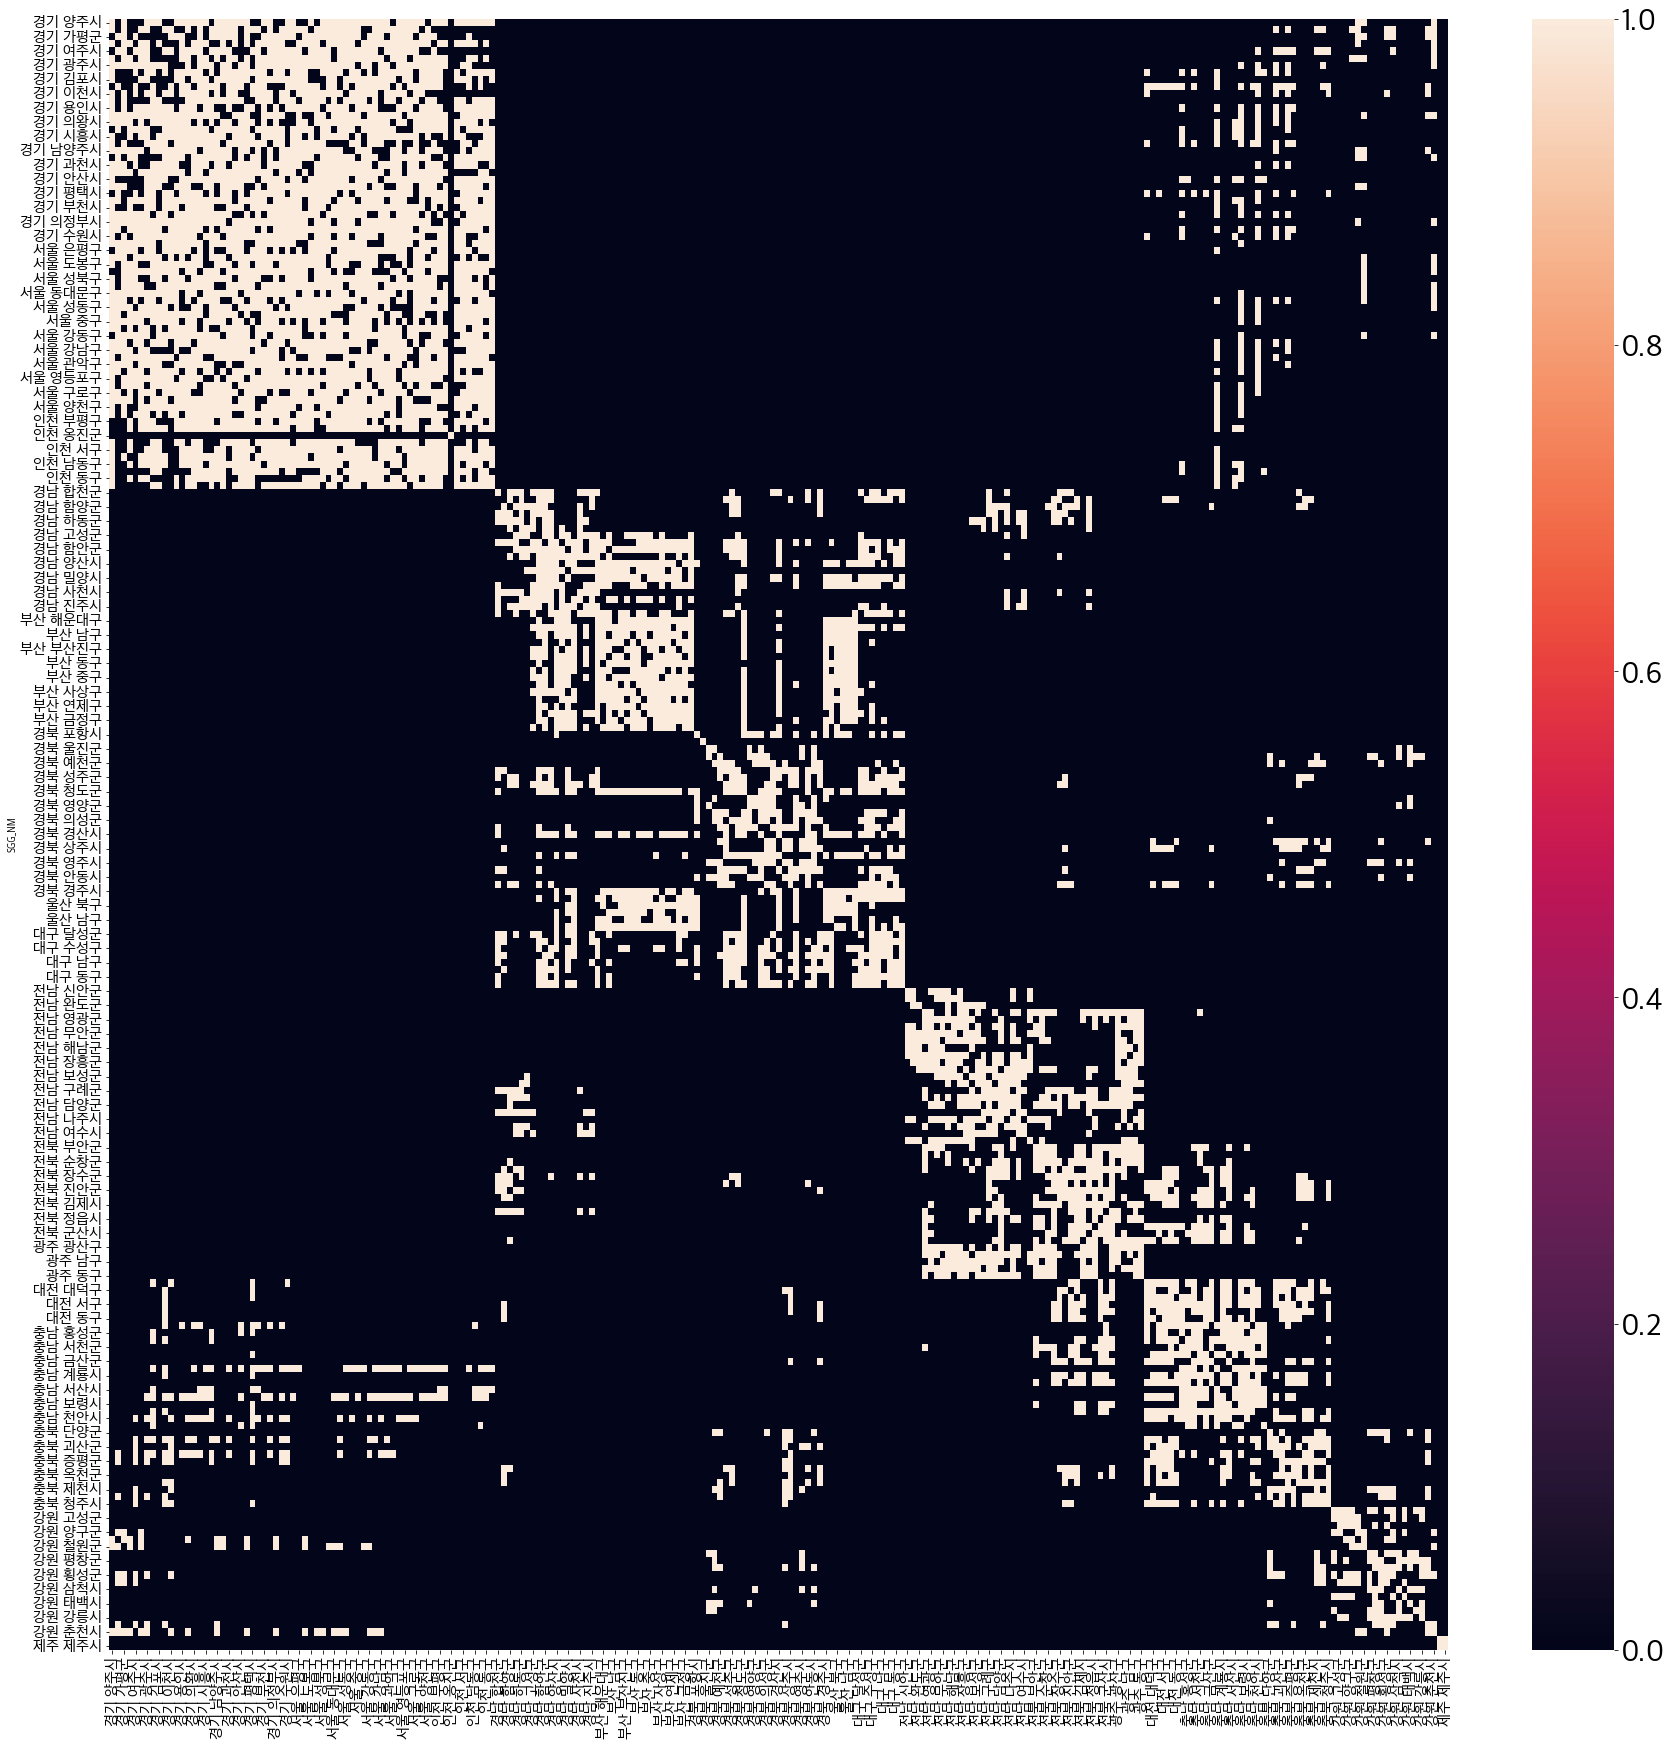

In [150]:
# 20% drop
import seaborn as sns
import matplotlib.pyplot as plt
tmp = pd.DataFrame(adj_mx.numpy(), columns = dist_mx.columns, index = dist_mx.index)
plt.figure(figsize=(30,30))
g=sns.heatmap(tmp) #annot=True,

cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.yticks(fontsize=15, rotation=0)
plt.xticks(fontsize=15, rotation=90)
plt.show()

In [126]:
adj_mx

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [ ]:
adj_mx[edge][행]
adj_mx[edge][열]

In [113]:
tmp = np.array([[1,2,3],
                [2,3,4],
                [0,1,2]])
tmp[[0,1,2],[1,2,0]] = 0
tmp

array([[1, 0, 3],
       [2, 3, 0],
       [0, 1, 2]])

In [ ]:
def randomedge_sampler(self, percent, normalization, cuda):
    """
    Randomly drop edge and preserve percent% edges.
    """
    "Opt here"
    if percent >= 1.0:
        return self.stub_sampler(normalization, cuda)
    
    nnz = self.train_adj.nnz # nonzero 인 녀석들
    perm = np.random.permutation(nnz) #nonzero인 녀석들 중 번호를 랜덤으로 섞기
    preserve_nnz = int(nnz*percent)
    perm = perm[:preserve_nnz]
    r_adj = sp.coo_matrix((self.train_adj.data[perm],
                            (self.train_adj.row[perm],
                            self.train_adj.col[perm])),
                            shape=self.train_adj.shape)
    r_adj = self._preprocess_adj(normalization, r_adj, cuda)
    fea = self._preprocess_fea(self.train_features, cuda)
    return r_adj, fea

In [ ]:
def stub_sampler(self, normalization, cuda):
    """
    The stub sampler. Return the original data. 
    """
    if normalization in self.trainadj_cache:
        r_adj = self.trainadj_cache[normalization]
    else:
        r_adj = self._preprocess_adj(normalization, self.train_adj, cuda)
        self.trainadj_cache[normalization] = r_adj
    fea = self._preprocess_fea(self.train_features, cuda)
    return r_adj, fea

In [ ]:
def _preprocess_adj(self, normalization, adj, cuda):
    adj_normalizer = fetch_normalization(normalization)
    r_adj = adj_normalizer(adj)
    r_adj = sparse_mx_to_torch_sparse_tensor(r_adj).float()
    if cuda:
        r_adj = r_adj.cuda()
    return r_adj

def _preprocess_fea(self, fea, cuda):
    if cuda:
        return fea.cuda()
    else:
        return fea